### Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')   

### Loading the Data

In [2]:
# Load training data (transactions)
train_data = pd.read_csv('/Users/sakshiii/Desktop/credit_card_fraud_detection/data/train.csv')       

# Load customer data
customer_data = pd.read_csv('/Users/sakshiii/Desktop/credit_card_fraud_detection/data/customer.csv') 

# Load terminal (merchant) data
terminal_data = pd.read_csv('/Users/sakshiii/Desktop/credit_card_fraud_detection/data/terminal.csv') 

# Load test data
test_data = pd.read_csv('/Users/sakshiii/Desktop/credit_card_fraud_detection/data/test.csv')


###  Exploratory Data Analysis (EDA)

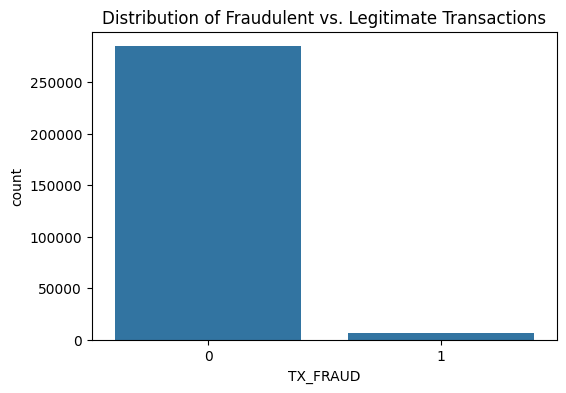

Percentage of fraudulent transactions: 2.2601%


In [3]:
# Check the distribution of the target variable
plt.figure(figsize=(6,4))
sns.countplot(x='TX_FRAUD', data=train_data)
plt.title('Distribution of Fraudulent vs. Legitimate Transactions')
plt.show()

# Display the percentage of fraudulent transactions
fraud_percentage = train_data['TX_FRAUD'].mean() * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.4f}%")


### Data Processsing 

#### 1. Handling Missing Values

In [4]:
# Check for missing values in train and test datasets
print("Missing values in Train Data:")
print(train_data.isnull().sum())

print("\nMissing values in Test Data:")
print(test_data.isnull().sum())

# Assuming no missing values for simplicity; otherwise, implement appropriate imputation


Missing values in Train Data:
TRANSACTION_ID    0
TX_DATETIME       0
CUSTOMER_ID       0
TERMINAL_ID       0
TX_AMOUNT         0
TX_FRAUD          0
dtype: int64

Missing values in Test Data:
TRANSACTION_ID    0
TX_DATETIME       0
CUSTOMER_ID       0
TERMINAL_ID       0
TX_AMOUNT         0
dtype: int64


#### 2. Feature Engineering

In [5]:
import ast

# Step 1: Parse the 'available_terminals' column from string to list format

# Define a function to safely convert the string representation of lists to actual lists
def convert_to_list(terminal_str):
    try:
        return ast.literal_eval(terminal_str)  # Safely evaluate string to list
    except (ValueError, SyntaxError):
        return []  # Return empty list if conversion fails
    
# Merge customer and terminal data
train_data = train_data.merge(customer_data, on='CUSTOMER_ID', how='left')
train_data = train_data.merge(terminal_data, on='TERMINAL_ID', how='left')

test_data = test_data.merge(customer_data, on='CUSTOMER_ID', how='left')
test_data = test_data.merge(terminal_data, on='TERMINAL_ID', how='left')

# Apply the conversion function to the 'available_terminals' column
train_data['available_terminals'] = train_data['available_terminals'].apply(convert_to_list)
test_data['available_terminals'] = test_data['available_terminals'].apply(convert_to_list)

# # Step 2: Feature: Count of available terminals for each customer
# train_data['num_available_terminals'] = train_data['available_terminals'].apply(len)
# test_data['num_available_terminals'] = test_data['available_terminals'].apply(len)

# Step 3: Drop the 'available_terminals' column after extracting useful information
train_data = train_data.drop('available_terminals', axis=1)
test_data = test_data.drop('available_terminals', axis=1)

# Step 4: Continue with other feature engineering steps
# Convert TX_DATETIME to datetime format
train_data['TX_DATETIME'] = pd.to_datetime(train_data['TX_DATETIME'])
test_data['TX_DATETIME'] = pd.to_datetime(test_data['TX_DATETIME'])

# Extract time-based features
train_data['hour'] = train_data['TX_DATETIME'].dt.hour
train_data['day_of_week'] = train_data['TX_DATETIME'].dt.dayofweek
train_data['month'] = train_data['TX_DATETIME'].dt.month

test_data['hour'] = test_data['TX_DATETIME'].dt.hour
test_data['day_of_week'] = test_data['TX_DATETIME'].dt.dayofweek
test_data['month'] = test_data['TX_DATETIME'].dt.month

# Transaction Recency (Time since last transaction per customer)
train_data['CUSTOMER_RECENCY'] = train_data.groupby('CUSTOMER_ID')['TX_DATETIME'].diff().dt.total_seconds()
train_data['TERMINAL_RECENCY'] = train_data.groupby('TERMINAL_ID')['TX_DATETIME'].diff().dt.total_seconds()



# # Feature: Distance between customer and terminal
# train_data['distance'] = np.sqrt((train_data['x_customer_id'] - train_data['x_terminal_id'])**2 +
#                                   (train_data['y_customer_id'] - train_data['y_terminal_id'])**2)

# test_data['distance'] = np.sqrt((test_data['x_customer_id'] - test_data['x_terminal_id'])**2 +
#                                  (test_data['y_customer_id'] - test_data['y_terminal_id'])**2)

# Dropping unnecessary columns
columns_to_drop = ['TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_DATETIME']
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)

# Display the updated train data after feature engineering
print("\nPreprocessed Training Data Head:")
print(train_data.head())



Preprocessed Training Data Head:
   TX_AMOUNT  TX_FRAUD  x_customer_id  y_customer_id  mean_amount  std_amount  \
0       4.60         0      84.515409      38.276422     7.353061    3.676530   
1       8.61         0      11.827443      63.992102    18.618562    9.309281   
2      64.00         0      75.221083      94.991427    82.620413   41.310207   
3      12.72         0      51.122179       8.329098     9.852171    4.926085   
4      98.88         0      62.777887      31.405270    83.660035   41.830018   

   mean_nb_tx_per_day  nb_terminals  x_terminal_id  y_terminal_id  hour  \
0            3.324124            19      80.316334      40.239252     0   
1            3.778676            16      15.172487      63.912685     0   
2            3.723765            13      74.196424      98.288079     0   
3            3.862067            15      51.950635       6.563484     0   
4            3.128315            20      62.417972      26.483666     0   

   day_of_week  month  
0   

### Handling Class Imbalance with Sampling


Validation Precision after Sampling: 0.0513

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     56931
           1       0.05      0.91      0.10      1316

    accuracy                           0.62     58247
   macro avg       0.52      0.76      0.43     58247
weighted avg       0.98      0.62      0.74     58247



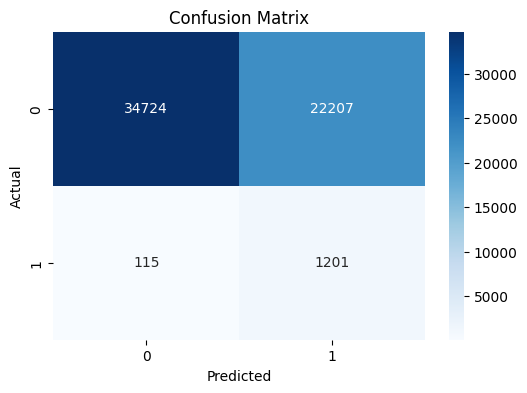

In [6]:
# Define features and target
X = train_data.drop('TX_FRAUD', axis=1)
y = train_data['TX_FRAUD']

# Split the data into training and validation sets before applying sampling to prevent data leakage
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the sampling strategy
# Combining SMOTE and Random Under Sampling
over = SMOTE(sampling_strategy=0.1, random_state=42)  # Oversample minority class to 10%
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Undersample majority class to have 0.5 ratio

# Create a pipeline
steps = [('over', over), ('under', under), ('scaler', StandardScaler()), ('model', XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss'))]
pipeline = Pipeline(steps=steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = pipeline.predict(X_val)

# Evaluate the model
precision = precision_score(y_val, y_pred)
print(f'\nValidation Precision after Sampling: {precision:.4f}')

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Display confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Adjusting Decision Threshold for Improved Precision

Precision with custom threshold 0.6: 0.0610

Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       1.00      0.69      0.81     56931
           1       0.06      0.87      0.11      1316

    accuracy                           0.69     58247
   macro avg       0.53      0.78      0.46     58247
weighted avg       0.97      0.69      0.80     58247



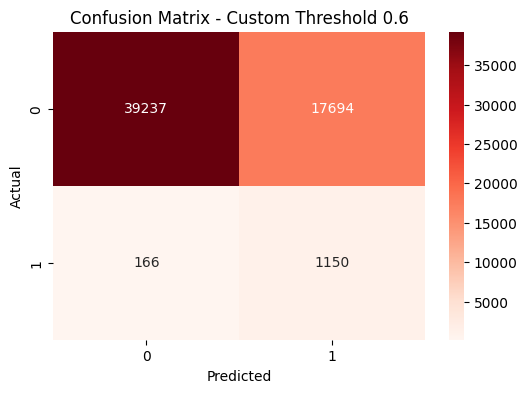

In [7]:
# Predict probabilities instead of labels
y_prob = pipeline.predict_proba(X_val)[:, 1]

# Set a custom threshold for fraud detection (e.g., 0.6)
custom_threshold = 0.6
y_pred_custom = (y_prob >= custom_threshold).astype(int)

# Recalculate precision with the new threshold
precision_custom = precision_score(y_val, y_pred_custom)
print(f'Precision with custom threshold {custom_threshold}: {precision_custom:.4f}')

# Display classification report and confusion matrix with custom threshold
print("\nClassification Report with Custom Threshold:")
print(classification_report(y_val, y_pred_custom))

# Confusion matrix with custom threshold
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_custom), annot=True, fmt='d', cmap='Reds')
plt.title(f'Confusion Matrix - Custom Threshold {custom_threshold}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter Tuning

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:24] WARN

[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.7s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.7s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   1.7s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.7s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   1.6s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:26] WARN

[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   3.0s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   3.0s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   3.1s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   1.8s
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   1.8s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   1.7s
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   1.8s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   3.1s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   3.1s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   3.3s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:29] WARN

[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   3.0s
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   1.6s
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   1.6s
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   2.9s
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   1.6s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:31] WARN

[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   3.1s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   3.2s
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   3.2s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   3.2s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   4.5s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   4.7s
[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   4.9s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   4.3s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   6.9s
[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   6.8s
[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   4.2s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   6.8s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   4.4s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   4.1s
[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   6.5s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   4.4s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   4.3s
[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   6.7s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   6.7s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   6.4s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   6.7s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   4.2s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   4.2s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   4.2s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.8s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   1.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   1.2s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   0.7s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   1.3s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   6.4s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   6.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   0.7s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   1.2s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   0.6s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   1.2s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   1.2s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   6.0s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100; total time=   0.8s


/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sakshiii/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:21:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   1.2s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   1.3s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   1.2s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   1.1s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   0.9s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   0.8s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   5.3s

Best Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_

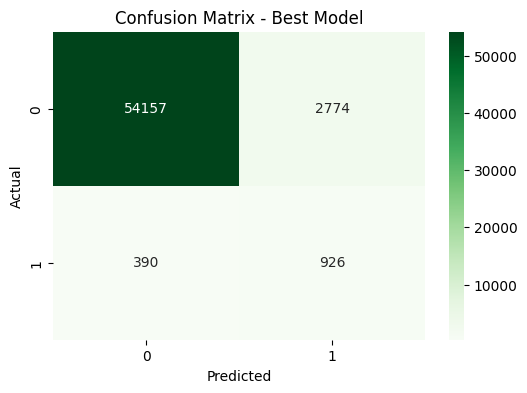

In [8]:
# Define the parameter grid for Random Forest
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='precision',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print(f"\nBest Parameters: {grid_search.best_params_}")

# Best estimator
best_model = grid_search.best_estimator_

# Predict on the validation set using the best model
y_pred_best = best_model.predict(X_val)

# Evaluate the best model
precision_best = precision_score(y_val, y_pred_best)
print(f'\nValidation Precision after Hyperparameter Tuning: {precision_best:.4f}')

print("\nClassification Report for Best Model:")
print(classification_report(y_val, y_pred_best))

# Display confusion matrix for the best model
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Precision with SMOTEENN: 0.0443

Classification Report for SMOTEENN:
              precision    recall  f1-score   support

           0       1.00      0.56      0.72     56931
           1       0.04      0.89      0.08      1316

    accuracy                           0.57     58247
   macro avg       0.52      0.72      0.40     58247
weighted avg       0.97      0.57      0.70     58247



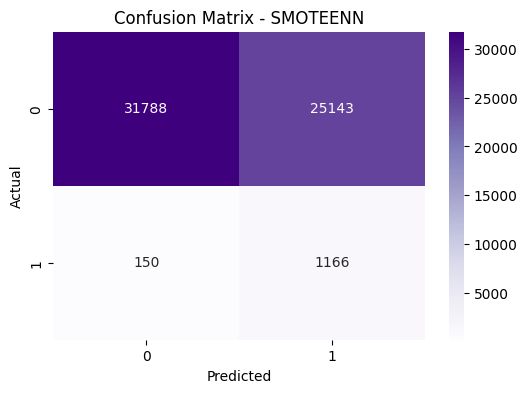

In [9]:
# Using SMOTEENN for a more balanced dataset
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Create a new pipeline with the resampled data
pipeline_smote_enn = Pipeline(steps=[('scaler', StandardScaler()), 
                                     ('model', XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss'))])

# Fit the model on resampled data
pipeline_smote_enn.fit(X_resampled, y_resampled)

# Predict on the validation set
y_pred_smote_enn = pipeline_smote_enn.predict(X_val)

# Evaluate the model
precision_smote_enn = precision_score(y_val, y_pred_smote_enn)
print(f'\nPrecision with SMOTEENN: {precision_smote_enn:.4f}')

# Display classification report and confusion matrix for SMOTEENN
print("\nClassification Report for SMOTEENN:")
print(classification_report(y_val, y_pred_smote_enn))

# Confusion matrix for SMOTEENN
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_smote_enn), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - SMOTEENN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [10]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

y_pred_iso = iso_forest.predict(X_val)
# Convert -1 (outlier) to 1 (fraud) and 1 (inlier) to 0 (not fraud)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
precision_iso = precision_score(y_val, y_pred_iso)
print(f'Precision with Isolation Forest: {precision_iso:.4f}')


Precision with Isolation Forest: 0.0205
